#### Only run after cleaning.ipynb

In [2]:
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import ADASYN
from sklearn.decomposition import PCA

In [3]:
from IPython.display import Audio

# create a PING noise to let you know modeling is done
sound_file = 'glass_ping-Go445-1207030150.mp3'
play_sound = Audio(sound_file, autoplay=True)

In [4]:
X_train = pd.read_pickle('X_train')
y_train = pd.read_pickle('y_train')
X_test = pd.read_pickle('X_test')
y_test = pd.read_pickle('y_test')

## Determining Scores

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, roc_auc_score

def scores(model, X_train, X_test, y_train, y_test, *args):
    '''
    input: the model you would like to test, while having train/test split
           initialized, normal nomenclature from sklearn train_test_split
    
    output: dictionary of scores for your model
    '''
    model_dic = {}
    
    # make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # scores for train
    model_dic['train_score'] = model.score(X_train, y_train)
    model_dic['train_precision'] = precision_score(y_train, train_pred)
    model_dic['train_recall'] = recall_score(y_train, train_pred)
    model_dic['train_f1'] = f1_score(y_train, train_pred)
    model_dic['train_confusion'] = confusion_matrix(y_train, train_pred, labels=[0, 1])
    model_dic['train_auc'] = roc_auc_score(y_train, train_pred)
    
    # scores for test
    model_dic['test_score'] = model.score(X_test, y_test)
    model_dic['test_precision'] = precision_score(y_test, test_pred)
    model_dic['test_recall'] = recall_score(y_test, test_pred)
    model_dic['test_f1'] = f1_score(y_test, test_pred)
    model_dic['test_confusion'] = confusion_matrix(y_test, test_pred, labels=[0, 1])
    model_dic['test_auc'] = roc_auc_score(y_test, test_pred)
    
    return model_dic

In [6]:
def percent_confusion(confusion_matrix, title='Confusion Matrix', annot=True, fmt='.2%'):
    '''
    A fuction to create % of total actual predictions
    
    input: confusion matrix values
    output: seaborn chart of percent of original 
    '''
    
    pred_true = confusion_matrix[1][1]
    pred_false_neg = confusion_matrix[1][0]
    pred_false = confusion_matrix[0][0]
    pred_false_pos = confusion_matrix[0][1]

    true_actual = confusion_matrix[1].sum()
    false_actual = confusion_matrix[0].sum()
    
    # creating a confusion matrix
    confusion = [[pred_false/false_actual, pred_false_pos/false_actual],
                 [pred_false_neg/true_actual, pred_true/true_actual]]
    
    plt.figure(figsize=(8,6))
    matrix = sns.heatmap(confusion, vmin=0, vmax=1, cmap='Blues', annot=annot, fmt=fmt)
    plt.xlabel('Predicted Values', labelpad=10, fontsize=12)
    plt.ylabel('Actual Values', labelpad=10, fontsize=12)
    plt.xticks(ticks=[.5,1.5],labels=['Not Fraud', 'Fraud'])
    plt.yticks(ticks=[.5,1.5],labels=['Not Fraud', 'Fraud'])
    plt.title(title, pad=10, fontsize=15)
    
    return plt.show()

## Vanilla XGBoost

In [10]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [11]:
%%time
# create an XGBoost model
xgb = XGBClassifier()

xgb.fit(X_train, y_train)

xgb_scores = scores(xgb, X_train, X_test, y_train, y_test)
play_sound

CPU times: user 3min 27s, sys: 2.39 s, total: 3min 29s
Wall time: 3min 23s


In [12]:
xgb_scores

{'train_score': 0.9723258938147007,
 'train_precision': 0.8606411398040962,
 'train_recall': 0.2494676388978512,
 'train_f1': 0.38681274701085594,
 'train_confusion': array([[426782,    626],
        [ 11631,   3866]]),
 'train_auc': 0.6240014981072567,
 'test_score': 0.9721136586852711,
 'test_precision': 0.85177733065057,
 'test_recall': 0.24583817266744096,
 'test_f1': 0.3815532522157128,
 'test_confusion': array([[142248,    221],
        [  3896,   1270]]),
 'test_auc': 0.6221434790086182}

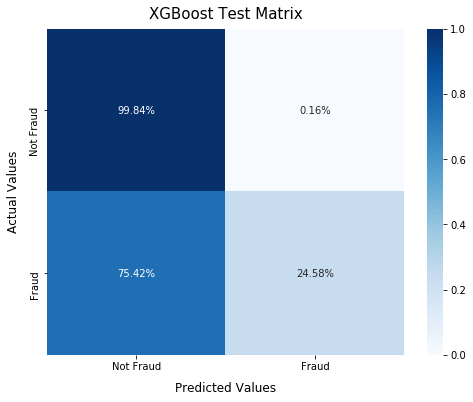

In [13]:
percent_confusion(xgb_scores['test_confusion'], title='XGBoost Test Matrix');

## Determine Important Features

In [14]:
xgb_imp = zip(X_train.columns, xgb.feature_importances_)
xgb_imp = pd.DataFrame(xgb_imp,
                       columns=['feature',
                                'importance']).sort_values('importance',
                                                           ascending=False).reset_index()
xgb_imp.drop(columns=['index'], inplace=True)

xgb_imp['cum_sum'] = xgb_imp['importance'].cumsum()

xgb_imp = xgb_imp[xgb_imp['cum_sum'] < .98]

In [15]:
important_features = xgb_imp['feature'].unique()

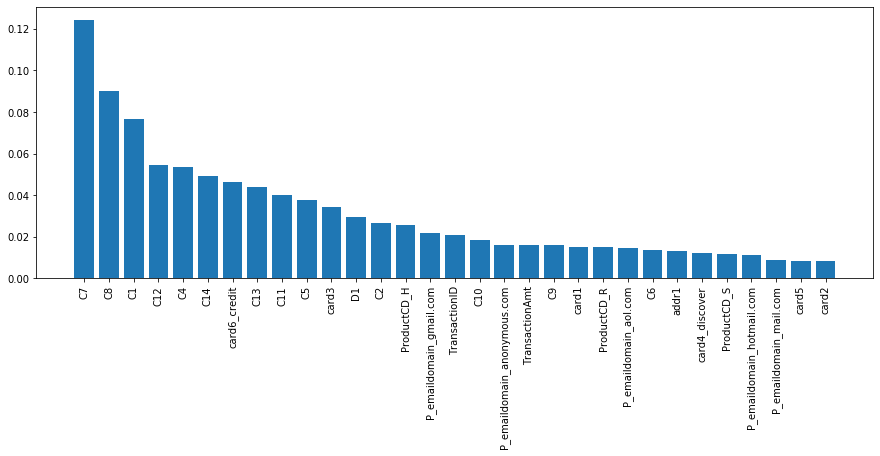

In [16]:
plt.figure(figsize=(15,5))
plt.bar('feature', 'importance', data=xgb_imp)
plt.xticks(rotation=90);

In [17]:
X_train = X_train[important_features]
X_test = X_test[important_features]

## Over Sampling

In [18]:
%%time
# ADASYN
ada = ADASYN('minority', random_state=42)
X_ada_train, y_ada_train = ada.fit_resample(X_train, y_train)
y_ada_train = pd.Series(y_ada_train)
X_ada_train = pd.DataFrame(X_ada_train, columns=X_train.columns)
X_ada_train.shape, y_ada_train.shape

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CPU times: user 11.2 s, sys: 611 ms, total: 11.8 s
Wall time: 8.96 s


((852153, 31), (852153,))

In [19]:
del X_train, y_train

## Naive Bayes

In [20]:
from sklearn.naive_bayes import BernoulliNB

In [21]:
%%time
clf = BernoulliNB()

clf.fit(X_ada_train, y_ada_train)

bern_scores = scores(clf, X_ada_train, X_test, y_ada_train, y_test)
play_sound

CPU times: user 9.11 s, sys: 451 ms, total: 9.56 s
Wall time: 2.67 s


In [22]:
bern_scores['test_auc']

0.664957791267383

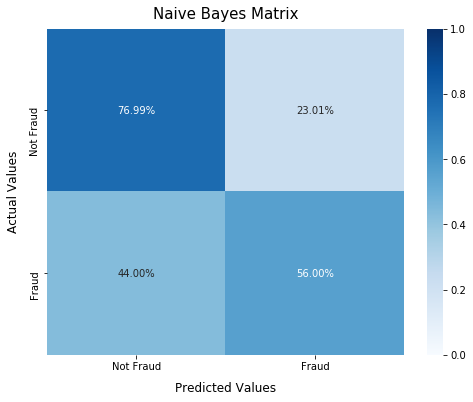

In [23]:
percent_confusion(bern_scores['test_confusion'], title='Naive Bayes Matrix')

# KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
knn = KNeighborsClassifier()

In [26]:
%%time
knn.fit(X_ada_train, y_ada_train)

knn_scores = scores(knn, X_ada_train, X_test, y_ada_train, y_test)
play_sound

CPU times: user 1min 58s, sys: 456 ms, total: 1min 58s
Wall time: 1min 51s


In [27]:
knn_scores

{'train_score': 0.9321189974100895,
 'train_precision': 0.8853068802849737,
 'train_recall': 0.9923766024320475,
 'train_f1': 0.9357890635493457,
 'train_confusion': array([[372801,  54607],
        [  3238, 421507]]),
 'train_auc': 0.9323067173430032,
 'test_score': 0.8082229823551326,
 'test_precision': 0.09890833477733495,
 'test_recall': 0.5524583817266744,
 'test_f1': 0.1677787249052056,
 'test_confusion': array([[116468,  26001],
        [  2312,   2854]]),
 'test_auc': 0.6849777607276586}

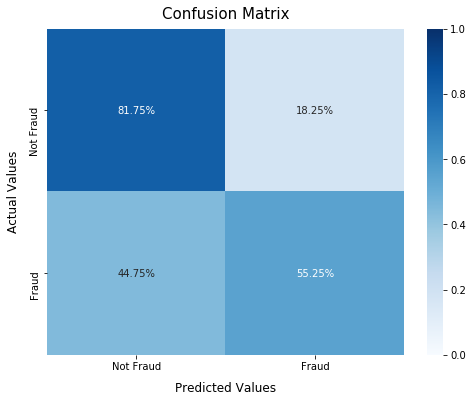

In [28]:
percent_confusion(knn_scores['test_confusion'])

## Decision Tree

In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image  
from pydotplus import graph_from_dot_data

In [92]:
clf = DecisionTreeClassifier(random_state=42, criterion='entropy')

In [93]:
%%time
clf.fit(X_ada_train, y_ada_train)

Dtree_scores = scores(clf, X_ada_train, X_test, y_ada_train, y_test)
play_sound

CPU times: user 19.3 s, sys: 187 ms, total: 19.4 s
Wall time: 15.2 s


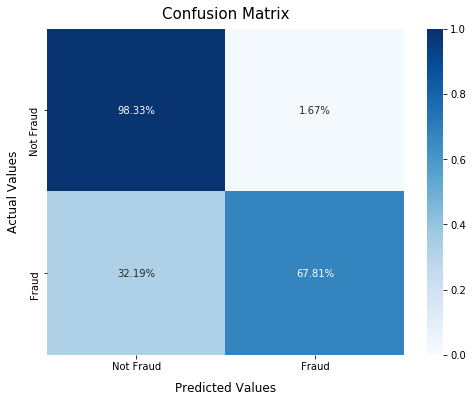

In [32]:
percent_confusion(Dtree_scores['test_confusion'])

In [140]:
feats = ['decision_path','feature','impurity','max_depth',
         'max_n_classes','n_classes','n_features','n_leaves',
         'n_node_samples','n_outputs','node_count',]

In [33]:
Dtree_scores

{'train_score': 1.0,
 'train_precision': 1.0,
 'train_recall': 1.0,
 'train_f1': 1.0,
 'train_confusion': array([[427408,      0],
        [     0, 424745]]),
 'train_auc': 1.0,
 'test_score': 0.972614894842009,
 'test_precision': 0.5954445011048785,
 'test_recall': 0.6780874951606659,
 'test_f1': 0.6340845325368811,
 'test_confusion': array([[140089,   2380],
        [  1663,   3503]]),
 'test_auc': 0.8306910533100005}

In [ ]:
visualize the Decision Tree

# # Create DOT data
# dot_data = export_graphviz(clf, out_file=None, 
#                            feature_names=X_ada_train.columns,  
#                            class_names=np.unique(y_ada_train).astype('str'), 
#                            filled=True, rounded=True, special_characters=True)

# # Draw graph
# graph = graph_from_dot_data(dot_data)  

# # Show graph
# Image(graph.create_png())

## Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
clf = RandomForestClassifier(criterion='entropy')

In [37]:
%%time
clf.fit(X_ada_train, y_ada_train)

RF_scores = scores(clf, X_ada_train, X_test, y_ada_train, y_test)
play_sound

CPU times: user 6min 54s, sys: 1.72 s, total: 6min 55s
Wall time: 4min 19s


In [40]:
RF_scores

{'train_score': 0.9999964795054409,
 'train_precision': 1.0,
 'train_recall': 0.9999929369386338,
 'train_f1': 0.9999964684568451,
 'train_confusion': array([[427408,      0],
        [     3, 424742]]),
 'train_auc': 0.9999964684693169,
 'test_score': 0.9862024587665527,
 'test_precision': 0.9408284023668639,
 'test_recall': 0.6463414634146342,
 'test_f1': 0.7662650602409639,
 'test_confusion': array([[142259,    210],
        [  1827,   3339]]),
 'test_auc': 0.8224337292716996}

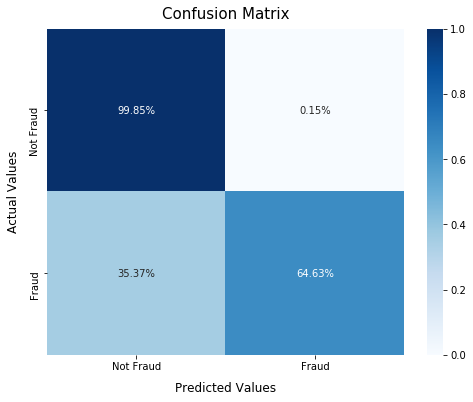

In [38]:
percent_confusion(RF_scores['test_confusion'])

In [56]:
from sklearn.model_selection import GridSearchCV

In [65]:
clf = RandomForestClassifier(random_state=42)

params = {'max_depth': [10, 30, 50, None],
          'min_samples_leaf': [1, 2, 4],
          'min_samples_split': [5, 10],
          'n_estimators': [30]}

rf_grid = GridSearchCV(estimator=clf,
                      param_grid=params,
                      cv=3, scoring='roc_auc',
                      n_jobs=-1)

In [66]:
rf_grid.fit(X_ada_train, y_ada_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [76]:
rf_scores = scores(rf_grid, X_ada_train, X_test, y_ada_train, y_test)

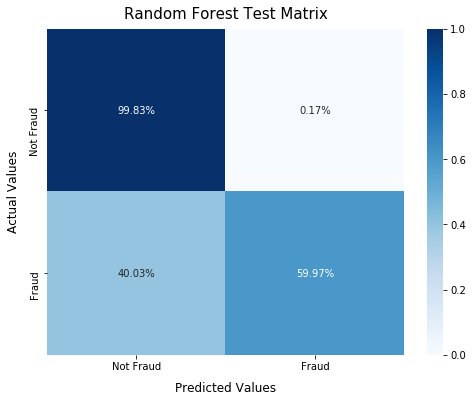

In [77]:
percent_confusion(rf_scores['test_confusion'], title='Random Forest Test Matrix');

In [78]:
play_sound

## XGBoost

In [51]:
%%time
# create an XGBoost model
xgb = XGBClassifier(max_depth=20)

xgb.fit(X_ada_train, y_ada_train)

xgb_scores = scores(xgb, X_ada_train, X_test, y_ada_train, y_test)
play_sound

CPU times: user 19min 4s, sys: 2.7 s, total: 19min 7s
Wall time: 19min 2s


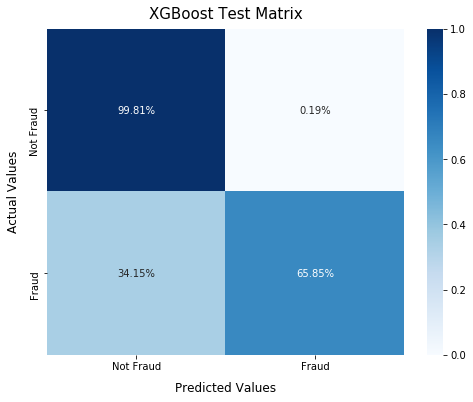

In [53]:
percent_confusion(xgb_scores['test_confusion'], title='XGBoost Test Matrix');

In [41]:
knn_scores['test_auc']

0.6849777607276586

In [42]:
Dtree_scores['test_auc']

0.8306910533100005

In [43]:
RF_scores['test_auc']

0.8224337292716996

In [79]:
xgb_scores['test_auc']

0.7989712669920379